# Thermo-elastic evolution problem (full coupling)

## Introduction

In this tour, we will solve a transient thermoelastic evolution problem in which both thermo-mechanical fields are fully coupled, we will however assume that the evolution is quasi-static and will hence neglect inertial effects. Note that a staggered approach could also have been adopted in which one field is calculated first (say the temperature for instance) using predicted values of the other field and similarly for the other field in a second step (see for instance [[FAR91]](#References)).

## Problem position

The problem consists of a quarter of a square plate perforated by a circular hole. Thermo-elastic properties are isotropic and correspond to those of aluminium (note that stress units are in $\text{MPa}$, distances in $\text{m}$ and mass in $\text{kg}$). Linearized thermo-elasticity will be considered around a reference temperature of $T_0 = 293 \text{ K}$. A temperature increase of $\Delta T=+10^{\circ}\text{C}$ will be applied on the hole boundary. Symmetry conditions are applied on the corresponding symmetry planes and stress and flux-free boundary conditions are adopted on the plate outer boundary.

We first import the relevant modules and define the mesh and material parameters (see [the next section](#Variational-formulation-and-time-discretization) for more details on the parameters).

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

L = 1.
R = 0.1
N = 50  # mesh density

domain = Rectangle(Point(0., 0.), Point(L, L)) - Circle(Point(0., 0.), R, 100)
mesh = generate_mesh(domain, N)

T0 = Constant(293.)
DThole = Constant(10.)
E = 70e3
nu = 0.3
lmbda = Constant(E*nu/((1+nu)*(1-2*nu)))
mu = Constant(E/2/(1+nu))
rho = Constant(2700.)     # density
alpha = 2.31e-5  # thermal expansion coefficient
kappa = Constant(alpha*(2*mu + 3*lmbda))
cV = Constant(910e-6)*rho  # specific heat per unit volume at constant strain
k = Constant(237e-6)  # thermal conductivity

We now define the relevant FunctionSpace for the considered problem. Since we will adopt a monolithic approach i.e. in which both fields are coupled and solved at the same time, we will need to resort to a Mixed FunctionSpace for both the displacement $\boldsymbol{u}$ and the temperature variation $\Theta=T-T_0$. For an introduction on the use of Mixed FunctionSpace, check out the FEniCS tutorials on the [mixed Poisson equation](http://fenics.readthedocs.io/projects/dolfin/en/2017.2.0/demos/mixed-poisson/python/demo_mixed-poisson.py.html Stokes problem) or the [Stokes problem](http://fenics.readthedocs.io/projects/dolfin/en/2017.2.0/demos/stokes-iterative/python/demo_stokes-iterative.py.html). Let us just point out that the constructor using `MixedFunctionSpace` has been deprecated since version 2016.2 (see [this post](https://fenicsproject.org/qa/11983/mixedfunctionspace-in-2016-2-0/)). In the following code, `MixedElement([Vue, Vte])` could also be replaced by `Vue * Vte`. 

In [2]:
Vue = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
Vte = FiniteElement('CG', mesh.ufl_cell(), 1) # temperature finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vte]))

def inner_boundary(x, on_boundary):
    return near(x[0]**2+x[1]**2, R**2, 1e-3) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary

bc1 = DirichletBC(V.sub(0).sub(1), Constant(0.), bottom) 
bc2 = DirichletBC(V.sub(0).sub(0), Constant(0.), left)
bc3 = DirichletBC(V.sub(1), DThole, inner_boundary) 
bcs = [bc1, bc2, bc3]

Dirichlet boundary conditions must be defined from the full FunctionSpace `V` using the appropriate subspaces that is `V.sub(0)` for the displacement (and `.sub(0)` or `.sub(1)` for the corresponding x/y component) and `V.sub(1)` for the temperature. Note also that in the following, we will in fact work with the temperature variation $\Theta = T-T_0$ as a field unkwown instead of the total temperature. Hence, the boundary condition on the hole boundary reads indeed as $\Delta T=+10^{\circ}\text{C}$ .

> **Note:** The definition of the `inner_boundary` region used the syntax `near(expr, value, tolerance)` to define the region where `expr = value` up to the specified `tolerance`. The given tolerance is quite large given that `mshr` generates a faceted approximation of a Circle (here using 100 segments). Mesh nodes may therefore not lie exactly on the true circle.

## Variational formulation and time discretization

The linearized thermoelastic constitutive equations are given by:

$$\begin{equation}
\boldsymbol{\sigma} = \mathbb{C}:(\boldsymbol{\varepsilon}-\alpha(T-T_0)\boldsymbol{1}) = \lambda\text{tr}(\boldsymbol{\varepsilon})\boldsymbol{1}+2\mu\boldsymbol{\varepsilon} -\kappa(T-T_0)\boldsymbol{1} 
\end{equation}$$

$$\begin{equation}
\rho s = \rho s_0 + \dfrac{\rho C_{\varepsilon}}{T_0}(T-T_0) + \kappa\text{tr}(\boldsymbol{\varepsilon})
\end{equation}$$

* $\lambda,\mu$ the Lamé coefficients
* $\rho$ material density
* $\alpha$ thermal expansion coefficient
* $\kappa = \alpha(3\lambda+2\mu)$
* $C_{\varepsilon}$ the specific heat at constant strain (per unit of mass).
* $s$ (resp. $s_0$) the entropy per unit of mass in the current (resp. initial configuration)

These equations are completed by the equilibrium equation which will later be expressed in its weak form (virtual work principle) and the linearized heat equation (without source terms):

$$\begin{equation}
\rho T_0 \dot{s} + \text{div} \boldsymbol{q}= 0
\end{equation}$$

where the heat flux is related to the temperature gradient through the isotropic Fourier law: $\boldsymbol{q} = - k\nabla T$ with $k$ being the thermal conductivity. Using the entropy constitutive relation, the weak form of the heat equation reads as:

$$\begin{equation}
\int_{\Omega}\rho T_0 \dot{s}\widehat{T}d\Omega - \int_{\Omega} \boldsymbol{q}\cdot\nabla \widehat{T}d\Omega= -\int_{\partial \Omega} \boldsymbol{q}\cdot\boldsymbol{n} \widehat{T} dS \quad \forall \widehat{T} \in V_T
\end{equation}$$

$$\begin{equation}
\int_{\Omega}\left(\rho C_{\varepsilon}\dot{T} + \kappa T_0\text{tr}(\dot{\boldsymbol{\varepsilon}})\right) \widehat{T}d\Omega + \int_{\Omega} k \nabla T\cdot\nabla \widehat{T}d\Omega= \int_{\partial \Omega} k\partial_n T \widehat{T} dS \quad \forall \widehat{T} \in V_T
\end{equation}$$

with $V_T$ being the FunctionSpace for the temperature field.

The time derivatives are now replaced by an implicit Euler scheme, so that the previous weak form at the time increment $n+1$ is now:

$$\begin{equation}
\int_{\Omega}\left(\rho C_{\varepsilon}\dfrac{T-T_n}{\Delta t} + \kappa T_0\text{tr}\left(\dfrac{\boldsymbol{\varepsilon}-\boldsymbol{\varepsilon}_n}{\Delta t}\right)\right) \widehat{T}d\Omega + \int_{\Omega} k \nabla T\cdot\nabla \widehat{T}d\Omega= \int_{\partial \Omega} k\partial_n T \widehat{T} dS \quad \forall \widehat{T} \in V_T \qquad (1)
\end{equation}$$

where $T$ and $\boldsymbol{\varepsilon}$ correspond to the *unknown* fields at the time increment $n+1$. For more details on the time discretization of the heat equation, see also the [Heat equation FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/._ftut1006.html).

In addition to the previous thermal weak form, the mechanical weak form reads as:

$$\begin{equation}
\int_{\Omega} \left(\lambda\text{tr}(\boldsymbol{\varepsilon})\boldsymbol{1}+2\mu\boldsymbol{\varepsilon} -\kappa(T-T_0)\boldsymbol{1}\right) :\nabla^s\widehat{\boldsymbol{v}}\text{ d} \Omega = W_{ext}(\widehat{\boldsymbol{v}}) \quad \forall \widehat{\boldsymbol{v}}\in V_U \qquad (2)
\end{equation}$$

where $V_U$ is the displacement FunctionSpace and $W_{ext}$ the linear functional corresponding to the work of external forces.

The solution of the coupled problem at $t=t_{n+1}$ is now $(\boldsymbol{u}_{n+1},T_{n+1})=(\boldsymbol{u},T)\in V_U\times V_T$ verifying $(1)$ and $(2)$. These two forms are implemented below with zero right-hand sides (zero Neumann BCs for both problems here). One slight modification is that the temperature unknown $T$ is replaced by the temperature variation $\Theta=T-T_0$ which appears naturally in the stress constitutive relation.

> **Note**: We will later make use of the `lhs` and `rhs` functions to extract the corresponding bilinear and linear forms.

In [3]:
U_ = TestFunction(V)
(u_, Theta_) = split(U_)
dU = TrialFunction(V)
(du, dTheta) = split(dU)
Uold = Function(V)
(uold, Thetaold) = split(Uold)


def eps(v):
    return sym(grad(v))


def sigma(v, Theta):
    return (lmbda*tr(eps(v)) - kappa*Theta)*Identity(2) + 2*mu*eps(v)


dt = Constant(0.)
mech_form = inner(sigma(du, dTheta), eps(u_))*dx
therm_form = (cV*(dTheta-Thetaold)/dt*Theta_ +
              kappa*T0*tr(eps(du-uold))/dt*Theta_ +
              dot(k*grad(dTheta), grad(Theta_)))*dx
form = mech_form + therm_form

## Resolution

The problem is now solved by looping over time increments. Because of the typical exponential time variation of temperature evolution of the heat equation, time steps are discretized on a non-uniform (logarithmic) scale. $\Delta t$ is therefore updated at each time step. Note that since we work in terms of temperature variation and not absolute temperature all fields can be initialized to zero, otherwise $T$ would have needed to be initialized to the reference temperature $T_0$.

In [ ]:
Nincr = 100
t = np.logspace(1, 4, Nincr+1)
Nx = 100
x = np.linspace(R, L, Nx)
T_res = np.zeros((Nx, Nincr+1))
U = Function(V)
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
    T_res[:, i+1] = [U(xi, 0.)[2] for xi in x]

At each time increment, the variation of the temperature increase $\Theta$ along a line $(x, y=0)$ is saved in the `T_res` array. This evolution is plotted below. As expected, the temperature gradually increases over time, reaching eventually a uniform value of $+10^{\circ}\text{C}$ over infinitely long waiting time.

<IPython.core.display.Javascript object>


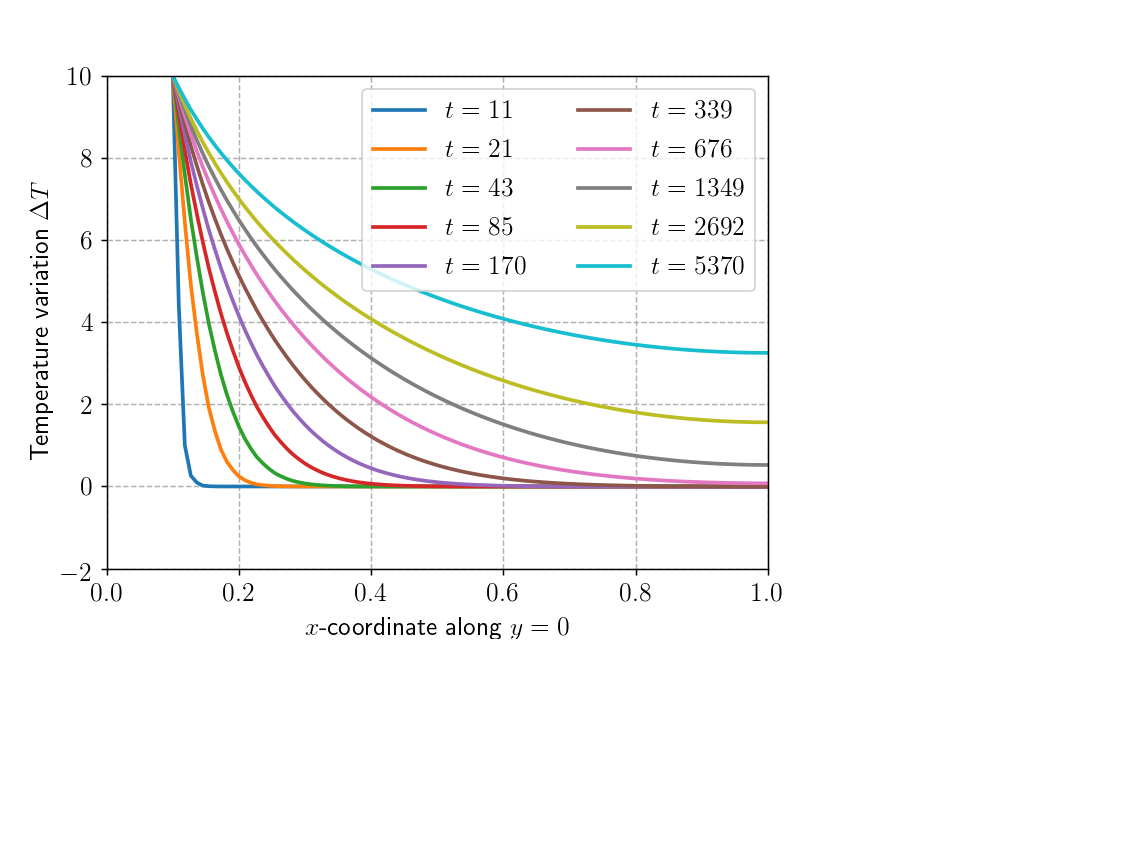

In [5]:
plt.figure()
plt.plot(x, T_res[:, 1::Nincr//10])
plt.xlabel("$x$-coordinate along $y=0$")
plt.ylabel("Temperature variation $\Theta$")
plt.legend(["$t={:.0f}$".format(ti) for ti in t[1::Nincr//10]], ncol=2)
plt.show()

The final stresses and temperature variation are plotted using `matplotlib`. Note that we can add colorbar and change the plot axis limit.

<IPython.core.display.Javascript object>


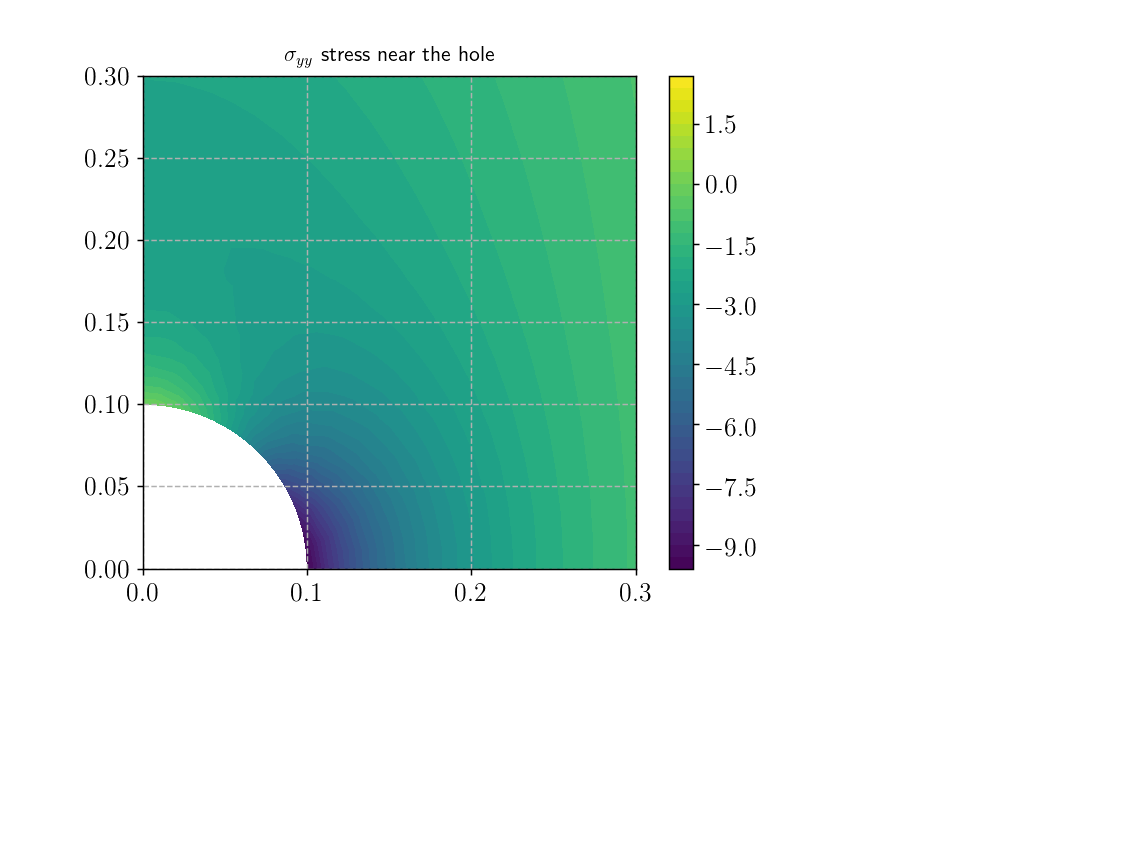

<IPython.core.display.Javascript object>


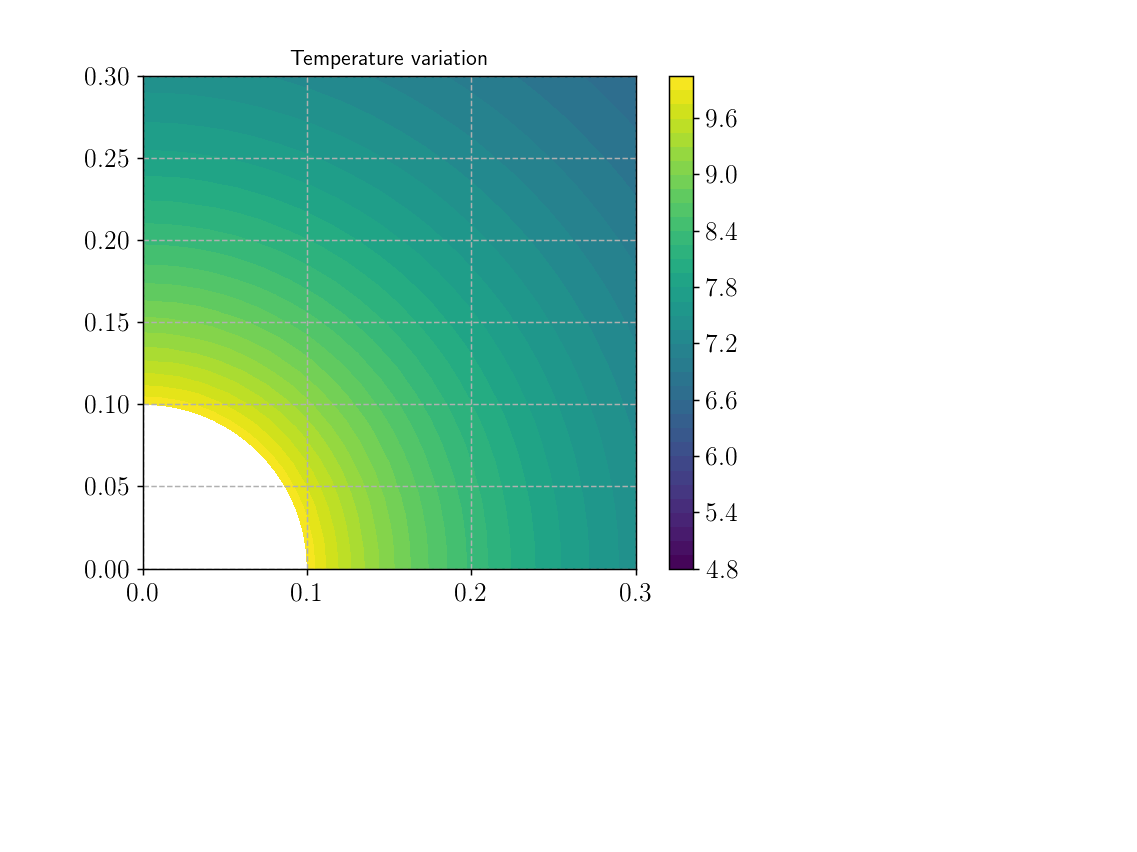

In [6]:
u, Theta = split(U)

plt.figure()
p = plot(sigma(u, Theta)[1, 1], title="$\sigma_{yy}$ stress near the hole")
plt.xlim((0, 3*R))
plt.ylim((0, 3*R))
plt.colorbar(p)
plt.show()

plt.figure()
p = plot(Theta, title="Temperature variation")
plt.xlim((0, 3*R))
plt.ylim((0, 3*R))
plt.colorbar(p)
plt.show()

## References

[FAR91]: Farhat, C., Park, K. C., & Dubois-Pelerin, Y. (1991). An unconditionally stable staggered algorithm for transient finite element analysis of coupled thermoelastic problems. Computer Methods in Applied Mechanics and Engineering, 85(3), 349-365. https://doi.org/10.1016/0045-7825(91)90102-C